In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pylab as plt

from mpl_toolkits.mplot3d import Axes3D

import rotate
from lassiAnalysis import regridXYZ
from utils import midPoint, gridLimits
from simulateSignal import zernikePoly
from zernikies import getZernikeCoeffs
from parabolas import rotateData, newParabola, fitLeicaData

In [3]:
def make_dish(xx, yy, f, x0, y0, z0):
    """
    """
    
    return (1./(4.*f))*(xx - x0)**2. + (1./(4.*f))*(yy - y0)**2. + z0

In [247]:
n = 512
f = 60.
x0 = 0.
y0 = 0.
z0 = -50.
thetaX = np.deg2rad(0./3600.)
thetaY = np.deg2rad(0./3600.)
x0map = 0.
y0map = 50.
xmin = -50. + x0map
xmax = 50. + x0map
ymin = -50. + y0map
ymax = 50. + y0map
dx = (xmax - xmin)/n
dy = (ymax - ymin)/n

In [248]:
grid_xy = np.mgrid[xmin:xmax:dx,
                   ymin:ymax:dy]
xx = grid_xy[0]
yy = grid_xy[1]

In [249]:
# Add noise to the grid positions.
xy_rms = 1e-6
xx_ref = xx + np.random.normal(0.0, xy_rms, xx.shape)
yy_ref = yy + np.random.normal(0.0, xy_rms, yy.shape)
xx_sig = xx + np.random.normal(0.0, xy_rms, xx.shape)
yy_sig = yy + np.random.normal(0.0, xy_rms, yy.shape)

In [250]:
# Evaluate the dish.
zz_ref = make_dish(xx_ref, yy_ref, f, x0, y0, z0)
zz_sig = make_dish(xx_sig, yy_sig, f, x0, y0, z0)

In [251]:
# Our coordinates are wrong.
xx_sig += 0.
yy_sig += 0.

In [455]:
# The Zernike polynomails is at the center of the map.
x_mid = midPoint(xx)
y_mid = midPoint(yy)
print("Dish center: {},{}".format(x_mid, y_mid))

# Zernike polynomial with an amplitude of amp.
amp = 1.7e-3
coefficient = np.zeros(37)
coefficient[14] = amp
z_sim = zernikePoly(xx, yy, x_mid, y_mid, coefficients=coefficient)

# Gaussian noise to mimic the TLS noise.
tls_rms = 20e-8
z_ref_rms = np.random.normal(0.0, tls_rms, zz_ref.shape)
z_sig_rms = np.random.normal(0.0, tls_rms, zz_sig.shape)

zz_ref_dif = z_ref_rms
zz_sig_dif = z_sim + z_sig_rms

# Add the dish, TLS noise and Zernike signal.
zz_ref_tot = zz_ref + zz_ref_dif
zz_sig_tot = zz_sig + zz_sig_dif

Dish center: -0.09765625,49.90234375


In [441]:
xyz_sig = np.dot(rotate.invRx(thetaX), 
                 np.dot(rotate.invRy(thetaY), 
                        np.array((xx_sig.flatten(), yy_sig.flatten(), zz_sig_tot.flatten()))))
xxr_sig = xyz_sig[0]
yyr_sig = xyz_sig[1]
zzr_sig = xyz_sig[2]
xxr_sig.shape = yyr_sig.shape = zzr_sig.shape = (n,n)

In [442]:
xyz_ref = np.dot(rotate.invRx(thetaX), 
                 np.dot(rotate.invRy(thetaY), 
                        np.array((xx_ref.flatten(), yy_ref.flatten(), zz_ref_tot.flatten()))))
xxr_ref = xyz_ref[0]
yyr_ref = xyz_ref[1]
zzr_ref = xyz_ref[2]
xxr_ref.shape = yyr_ref.shape = zzr_ref.shape = (n,n)

In [443]:
masked_fitresult = fitLeicaData(xxr_sig, yyr_sig, zzr_sig, [60., 0., 0., -50., 0., 0.], weights=None)
c = masked_fitresult.x
print(c)
x_sig_fit, y_sig_fit, z_sig_fit = newParabola(xxr_sig, yyr_sig, zzr_sig, c[0], c[1], c[2], c[3], c[4], c[5])
xx_sig_rot, yy_sig_rot, zz_sig_rot = rotateData(xxr_sig, yyr_sig, zzr_sig, c[4], c[5])

[ 5.99998220e+01  5.77171554e-02 -9.25883220e-05 -5.00000329e+01
  1.85596475e-06  6.40605974e-04]


In [444]:
print(f, (c[0] - f)/f*100.)
print(x0, (c[1] - x0)/x0*100.)
print(y0, (c[2] - y0)/y0*100.)
print(z0, (c[3] - z0)/z0*100.)
print(thetaX, (c[4] - thetaX)/thetaX*100.)
print(thetaY, (c[5] - thetaY)/thetaY*100.)

60.0 -0.00029673124547713314
0.0 inf
0.0 -inf
-50.0 6.579390301908461e-05
0.0 inf
0.0 inf


In [445]:
masked_fitresult = fitLeicaData(xxr_ref, yyr_ref, zzr_ref, [60., 0., 0., -50., 0., 0.], weights=None)
cr = masked_fitresult.x
print(cr)
x_ref_fit, y_ref_fit, z_ref_fit = newParabola(xxr_ref, yyr_ref, zzr_ref, 
                                              cr[0], cr[1], cr[2], cr[3], cr[4], cr[5])
xx_ref_rot, yy_ref_rot, zz_ref_rot = rotateData(xxr_ref, yyr_ref, zzr_ref, cr[4], cr[5])

[ 6.00000000e+01  2.08114432e-08 -1.37383169e-08 -5.00000000e+01
  2.54313131e-11  2.32446478e-10]


In [446]:
print(f, (cr[0] - f)/f*100.)
print(x0, (cr[1] - x0)/x0*100.)
print(y0, (cr[2] - y0)/y0*100.)
print(z0, (cr[3] - z0)/z0*100.)
print(thetaX, (cr[4] - thetaX)/thetaX*100.)
print(thetaY, (cr[5] - thetaY)/thetaY*100.)

60.0 2.1038708553078322e-08
0.0 inf
0.0 -inf
-50.0 2.0197745698169456e-09
0.0 inf
0.0 inf


In [447]:
print((c - cr)/c*100.)

[-2.96753165e-04  9.99999639e+01  9.99851619e+01  6.57918400e-05
  9.99986298e+01  9.99999637e+01]


<IPython.core.display.Javascript object>


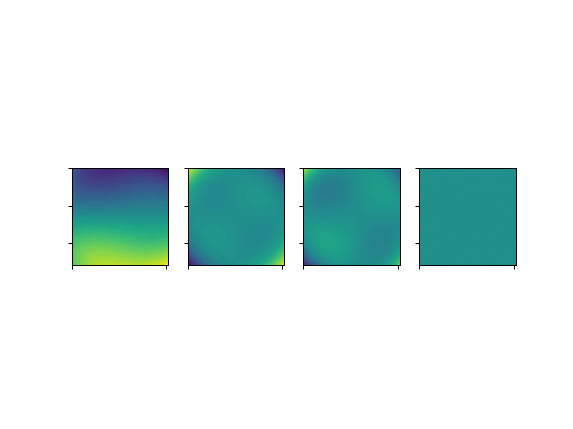

[]

In [448]:
plt.figure()

plt.subplot(141)
z_sig_fit.shape = (n,n)
plt.imshow(zz_sig_tot - z_sig_fit)
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(142)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(143)
zz_sig_rot.shape = (n,n)
plt.imshow(zz_sig_rot - z_sig_fit, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

plt.subplot(144)
zz_ref_rot.shape = (n,n)
z_ref_fit.shape = (n,n)
plt.imshow(zz_ref_rot - z_ref_fit, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))
plt.gca().set_yticklabels([])
plt.gca().set_xticklabels([])

In [449]:
xx_sig_rot.shape = (n,n)
yy_sig_rot.shape = (n,n)
zz_sig_rot.shape = (n,n)
z_sig_fit.shape = (n,n)

xx_ref_rot.shape = (n,n)
yy_ref_rot.shape = (n,n)
zz_ref_rot.shape = (n,n)
z_ref_fit.shape = (n,n)

diff_ref = zz_ref_rot - z_ref_fit
diff_sig = zz_sig_rot - z_sig_fit

<IPython.core.display.Javascript object>


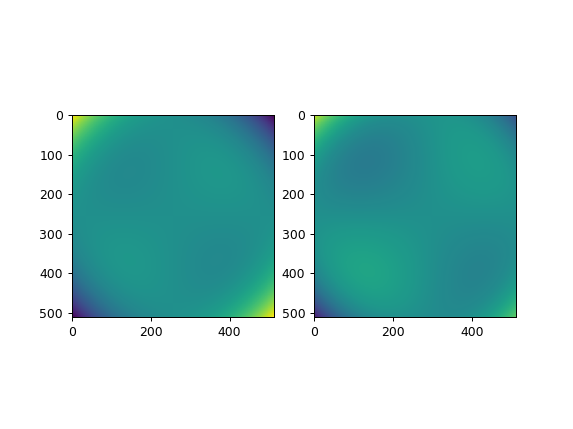

In [450]:
plt.figure()

plt.subplot(121)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

plt.subplot(122)

plt.imshow((zz_sig_rot - z_sig_fit) - (zz_ref_rot - z_ref_fit), 
           vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

In [451]:
xmin, xmax = gridLimits(xx_ref_rot, xx_sig_rot)
ymin, ymax = gridLimits(yy_ref_rot, yy_sig_rot)

xxrr,yyrr,zzrr = regridXYZ(xx_ref_rot, yy_ref_rot, diff_ref, 
                           n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

xxsr,yysr,zzsr = regridXYZ(xx_sig_rot, yy_sig_rot, diff_sig, 
                           n=n, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

<IPython.core.display.Javascript object>


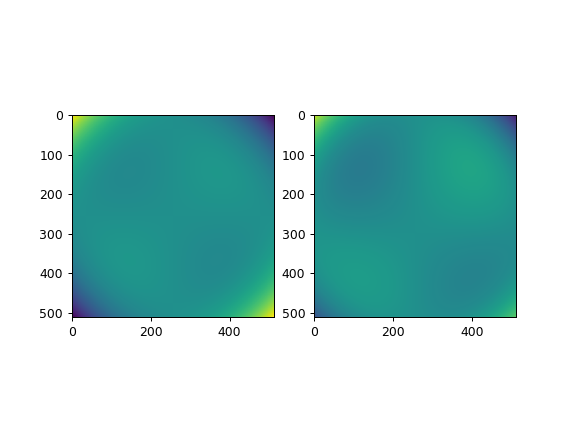

In [452]:
plt.figure()

plt.subplot(121)
plt.imshow(zz_sig_dif, vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

plt.subplot(122)
plt.imshow((zzsr - zzrr), vmin=np.nanmin(zz_sig_dif), vmax=np.nanmax(zz_sig_dif))

<IPython.core.display.Javascript object>


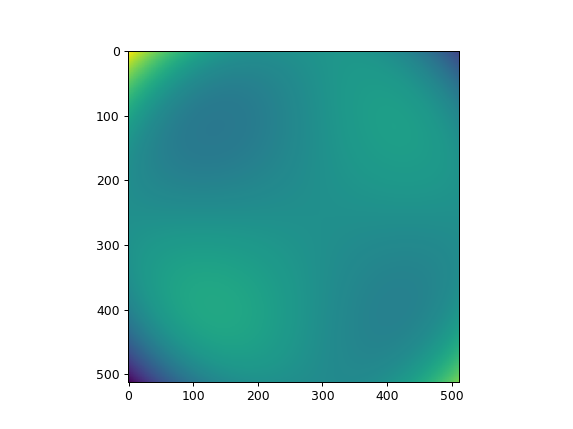

In [453]:
diff = (zz_sig_rot - z_sig_fit) - (zz_ref_rot - z_ref_fit)

plt.figure()

plt.imshow(diff)

<IPython.core.display.Javascript object>


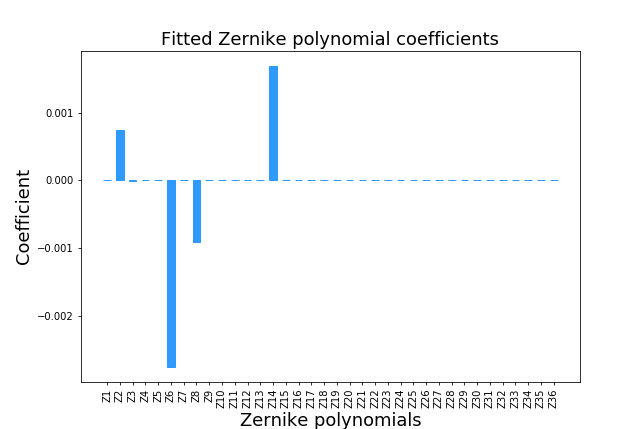

CPU times: user 41.4 s, sys: 13.1 ms, total: 41.4 s
Wall time: 41.4 s


In [454]:
%%time

fitlist = getZernikeCoeffs(diff.T, 36, barChart=True, norm='active-surface')